In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import time
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import NuSVR
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

sns.set(style='whitegrid',color_codes=True)

Using TensorFlow backend.


In [2]:
data=pd.read_csv(r'Parkinsons.csv')

In [3]:
scaler=MinMaxScaler()
scaler.fit(data)
scaled_data=scaler.transform(data)

D:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [4]:
X=scaled_data[:,1:]
Y=scaled_data[:,0]
X_values = X.astype('float64')
Y_values = Y.astype('float64')

In [5]:
x_train,x_test,y_train,y_test=train_test_split(X_values,Y_values,test_size=0.3,random_state=23)

In [6]:
est=[LinearRegression(),
     SGDRegressor(random_state=23),
     ElasticNet(random_state=23),Lars(),LassoLars(),
     BayesianRidge(),
     DecisionTreeRegressor(random_state=23),
     KNeighborsRegressor(n_jobs=-1),
     LinearSVR(random_state=23),NuSVR(),SVR(kernel='rbf'),
     KernelRidge(alpha=1.0),
     ExtraTreesRegressor(n_jobs=-1,random_state=23),
     RandomForestRegressor(n_jobs=-1,random_state=23),
     GradientBoostingRegressor(random_state=23),
     BaggingRegressor(n_jobs=-1,random_state=23),
     AdaBoostRegressor(random_state=23),
     XGBRegressor(random_state=23)
    ]


model_names=['LinearRegression',
             'SGDRegressor',
             'ElasticNet','Lars','LassoLars',
             'BayesianRidge',
             'Tree',
             'KNN',
             'LinearSVR','Nu_rbf_SVR','rbf_SVR',
             'KernelRidge',
             'ExtraTrees','RandomForest',
             'GradientBoosting','Bagging','AdaBoost',
             'XGBoost'
            ]

mse=[]
t=[]
for m in range(len(est)):
    time_start = time.time()
    scores = -cross_val_score(est[m],x_train,y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=-1).mean()
    time_end = time.time()
    t.append(time_end-time_start)
    mse.append(scores)
result_frame=pd.DataFrame({'Model':model_names,'MSE':mse,'Time':t})

In [7]:
NN_start = time.time()
modelNN = Sequential()
modelNN.add(Dense(128, input_shape=(19,), activation='relu'))
modelNN.add(Dense(64, activation='relu'))
modelNN.add(Dense(32, activation='relu'))
modelNN.add(Dense(16, activation='relu'))
modelNN.add(Dense(1, activation='sigmoid'))
modelNN.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
np.random.seed(23)
trainNN = modelNN.fit(x_train, y_train, batch_size=512, epochs=1000, verbose=0 ,validation_split=0.2,shuffle=True)
NN_end = time.time()

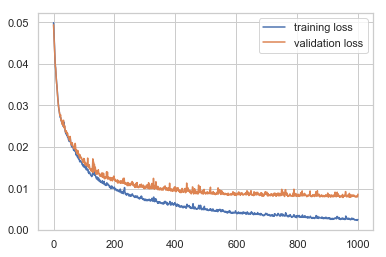

In [8]:
pyplot.plot(trainNN.history['loss'], label='training loss')
pyplot.plot(trainNN.history['val_loss'], label='validation loss')
pyplot.legend()
pyplot.show()

In [9]:
result_frame=result_frame.append([{'Model':'NN','MSE':min(trainNN.history['val_loss']),'Time':NN_end-NN_start}], ignore_index=True)

In [10]:
result_frame

,Model,MSE,Time
0,LinearRegression,0.041911,1.810616
1,SGDRegressor,0.044060,0.899492
2,ElasticNet,0.049725,0.015625
3,Lars,0.041853,0.015618
4,LassoLars,0.049725,0.015621
5,BayesianRidge,0.041790,0.000000
6,Tree,0.004223,0.088809
7,KNN,0.017458,0.130496
8,LinearSVR,0.043418,0.088760
9,Nu_rbf_SVR,0.041498,0.613517


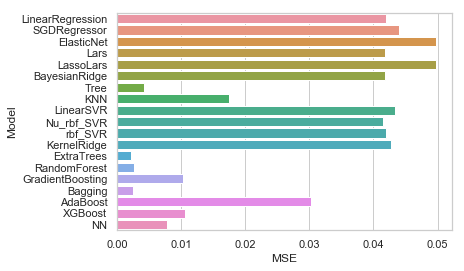

In [12]:
sns.barplot(y='Model',x='MSE',data=result_frame)

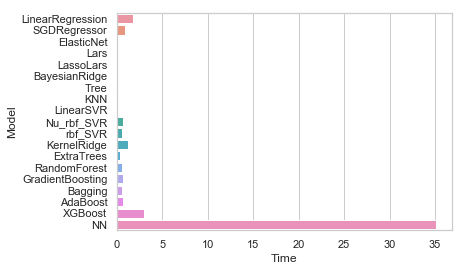

In [11]:
sns.barplot(y='Model',x='Time',data=result_frame)

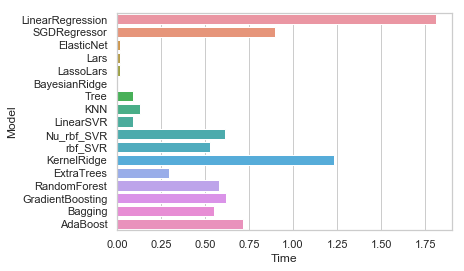

In [13]:
sns.barplot(y='Model',x='Time',data=result_frame[:-2])

<font size=5>参数调优</font>

1.Tree

In [14]:
params_dict={'min_impurity_decrease':[10**-i for i in range(11)]}
est_tree=GridSearchCV(estimator=DecisionTreeRegressor(random_state=23),
                      param_grid=params_dict,scoring='neg_mean_squared_error',cv=5 ,n_jobs=-1,verbose=1)
est_tree.fit(x_train,y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=23, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_impurity_decrease': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [15]:
est_tree.best_score_

-0.003909135781644034

In [16]:
est_tree.best_params_

{'min_impurity_decrease': 1e-09}

In [17]:
est_tree.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=1e-09,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=23, splitter='best')

2.KNN

In [18]:
n_neighbors=[i+1 for i in range(5)]
params_dict={'n_neighbors':n_neighbors}
est_knn=GridSearchCV(estimator=KNeighborsRegressor(n_jobs=-1)
                     ,param_grid=params_dict,scoring='neg_mean_squared_error',cv=5 ,n_jobs=-1,verbose=1)
est_knn.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [19]:
est_knn.best_score_

-0.01735236440097204

In [20]:
est_knn.best_params_

{'n_neighbors': 4}

In [21]:
est_knn.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
          weights='uniform')

3.ExtraTrees

In [22]:
params_dict={'n_estimators':[5,10,50,100,200,300],'bootstrap':[True,False]}
est_extratrees=GridSearchCV(estimator=ExtraTreesRegressor(n_jobs=-1,random_state=23),
                            param_grid=params_dict,scoring='neg_mean_squared_error',cv=5 ,n_jobs=-1,verbose=1)
est_extratrees.fit(x_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
          oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 200, 300], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [23]:
est_extratrees.best_score_

-0.001480019936806021

In [24]:
est_extratrees.best_params_

{'bootstrap': False, 'n_estimators': 200}

In [25]:
est_extratrees.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
          oob_score=False, random_state=23, verbose=0, warm_start=False)

4.RandomForest

In [26]:
params_dict={'n_estimators':[1000,2000,3000,4000],'max_features':['auto']}
est_rf=GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1,random_state=23),
                    param_grid=params_dict,scoring='neg_mean_squared_error',cv=5 ,n_jobs=-1,verbose=1)
est_rf.fit(x_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1000, 2000, 3000, 4000], 'max_features': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [27]:
est_rf.best_score_

-0.0019264327783254853

In [28]:
est_rf.best_params_

{'max_features': 'auto', 'n_estimators': 2000}

In [29]:
est_rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=23, verbose=0, warm_start=False)

5.GradientBoosting

In [30]:
params_dict={'n_estimators':[8000,9000,10000]}
est_gb=GridSearchCV(estimator=GradientBoostingRegressor(random_state=23),
                    cv=5,param_grid=params_dict,scoring='neg_mean_squared_error',n_jobs=-1,verbose=1)
est_gb.fit(x_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=23, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [8000, 9000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [31]:
est_gb.best_score_

-0.003528562809805733

In [32]:
est_gb.best_params_

{'n_estimators': 10000}

In [33]:
est_gb.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10000, n_iter_no_change=None, presort='auto',
             random_state=23, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

6.AdaBoost

In [34]:
params_dict={'n_estimators':[5,10,20,40,50,60]}
est_adaboost=GridSearchCV(estimator=AdaBoostRegressor(random_state=23),
                         param_grid=params_dict,scoring='neg_mean_squared_error',cv=5 ,n_jobs=-1,verbose=1)
est_adaboost.fit(x_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=23),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 20, 40, 50, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [35]:
est_adaboost.best_score_

-0.03022698807878166

In [36]:
est_adaboost.best_params_

{'n_estimators': 50}

In [37]:
est_adaboost.best_estimator_

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=23)

7.XGBoost

In [38]:
params_dict={'gamma':[10**-i for i in range(10)]}
est_xgb1=GridSearchCV(estimator=XGBRegressor(random_state=23)
                      ,param_grid=params_dict,scoring='neg_mean_squared_error',cv=5 ,n_jobs=-1,verbose=1)
est_xgb1.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=23,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [40]:
est_xgb1.best_score_

-0.0103760727937307

In [41]:
est_xgb1.best_params_

{'gamma': 0.01}

In [42]:
params_dict={'gamma':[0.01],'max_depth':[5,10,15]}
est_xgb2=GridSearchCV(estimator=XGBRegressor(random_state=23)
                      ,param_grid=params_dict,scoring='neg_mean_squared_error',cv=5 ,n_jobs=-1,verbose=1)
est_xgb2.fit(x_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    9.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=23,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': [0.01], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [43]:
est_xgb2.best_score_

-0.0020491089414601607

In [44]:
est_xgb2.best_params_

{'gamma': 0.01, 'max_depth': 10}

In [45]:
params_dict={'gamma':[0.01],'max_depth':[10],'subsample':[0.6, 0.7, 0.8, 0.9]}
est_xgb3=GridSearchCV(estimator=XGBRegressor(random_state=23)
                      ,param_grid=params_dict,scoring='neg_mean_squared_error',cv=5 ,n_jobs=-1,verbose=1)
est_xgb3.fit(x_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=23,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': [0.01], 'max_depth': [10], 'subsample': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [46]:
est_xgb3.best_score_

-0.001843602566765604

In [47]:
est_xgb3.best_params_

{'gamma': 0.01, 'max_depth': 10, 'subsample': 0.7}

In [48]:
params_dict={'gamma':[0.01],'max_depth':[10],'subsample':[0.7],'colsample_bytree':[0.8,0.9,1]}
est_xgb4=GridSearchCV(estimator=XGBRegressor(random_state=23)
                      ,param_grid=params_dict,scoring='neg_mean_squared_error',cv=5 ,n_jobs=-1,verbose=1)
est_xgb4.fit(x_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    9.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=23,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': [0.01], 'max_depth': [10], 'subsample': [0.7], 'colsample_bytree': [0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [49]:
est_xgb4.best_score_

-0.001843602566765604

In [50]:
est_xgb4.best_params_

{'colsample_bytree': 1, 'gamma': 0.01, 'max_depth': 10, 'subsample': 0.7}

In [51]:
params_dict={'n_estimators':[3000,4000,5000],'gamma':[0.01],'max_depth':[10],'subsample':[0.7],'colsample_bytree':[1]}
est_xgb5=GridSearchCV(estimator=XGBRegressor(random_state=23)
                      ,param_grid=params_dict,scoring='neg_mean_squared_error',cv=5 ,n_jobs=-1,verbose=1)
est_xgb5.fit(x_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=23,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [3000, 4000, 5000], 'gamma': [0.01], 'max_depth': [10], 'subsample': [0.7], 'colsample_bytree': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [54]:
est_xgb5.best_score_

-0.001741419034030562

In [52]:
est_xgb5.best_params_

{'colsample_bytree': 1,
 'gamma': 0.01,
 'max_depth': 10,
 'n_estimators': 5000,
 'subsample': 0.7}

In [53]:
est_xgb5.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=23,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

<font size=5>模型评估</font>

经过参数调优，舍弃Adaboost模型，ExtraTrees、GBoost、RandomForest、Tree、GBDT、KNN参与模型评估。

In [55]:
def evaluation(est):
    time_start=time.time()
    est.fit(x_train,y_train)
    y_pre=est.predict(x_test)
    explained_variance=explained_variance_score(y_test, y_pre)
    Mean_AE=mean_absolute_error(y_test, y_pre)
    r2=r2_score(y_test, y_pre)
    MSE=mean_squared_error(y_test, y_pre)
    time_end=time.time()
    return {'mean_squared_error':MSE,'mean_absolute_error':Mean_AE,
            'r2_score':r2,'explained_variance_score':explained_variance,
           'Time':time_end-time_start}

In [56]:
model_optimized=[LinearRegression(),est_extratrees.best_estimator_,est_xgb5.best_estimator_,
                 est_rf.best_estimator_,est_tree.best_estimator_,
                 est_gb.best_estimator_,est_knn.best_estimator_]
model_optimized_name=['LinearRegression','Extratrees','XGBoost','RandomForest','Tree','GBDT','KNN']

In [57]:
result_optimized_frame=pd.DataFrame()
for m in model_optimized:
    result_optimized_frame=result_optimized_frame.append(evaluation(m),ignore_index=True)
    
result_optimized_frame.insert(0,'model',model_optimized_name)
result_optimized_frame=result_optimized_frame[['model','mean_squared_error','mean_absolute_error',
                                               'r2_score','explained_variance_score','Time']]
result_optimized_frame

,model,mean_squared_error,mean_absolute_error,r2_score,explained_variance_score,Time
0,LinearRegression,0.039923,0.167874,0.197857,0.198841,0.044563
1,Extratrees,0.001294,0.019761,0.974009,0.974009,0.828662
2,XGBoost,0.001576,0.022685,0.968334,0.968338,96.594910
3,RandomForest,0.001472,0.018217,0.970423,0.970424,27.351404
4,Tree,0.003235,0.016100,0.934997,0.935001,0.124964
5,GBDT,0.003177,0.040200,0.936168,0.936192,44.009659
6,KNN,0.017121,0.077886,0.656008,0.656991,0.125154
